# MMDx: Mulitmodal Detection for Breast Cancer
### Combining Imaging, Genomic and Clinical Data to predict Breast cancer stage
#### Insight Data Science Sept-Oct 2017

Breast Cancer is the 2nd leading cause of cancer deaths in women in the US costing about $16.5million per year.
Most deaths are caused by late stage cancer. To prevent these deaths, screening tests should be developed that catch cancers early so that interventions can be implemented to slow the progress to late stage cancers. Staging is one such test that determines the level of progress of an existing tumour but it requires Imaging, Clinical, tissue biopsy and sometimes genomic data. An assessment (stage) is made based on the review of the results of these tests. This is obviously a cumbersome and often drawn out process. AI startups that have tried to help automate this process have focused mostly on imaging data alone or genomic data. Building a model that combines these data sources could provide more reliable and robust predictions at scale.

This project seeks to build a model that correctly predicts the stage of breast cancer (early or late) by combining Imaging, Genomic and Clinical data to improve Oncology decision support.

For the purpose of this project
- Early Stage - Stage 1a, 1b, 2a, 2b, 3a
- Late Stage - Stage 3b, 3c, 4

#### Data Source
National Institute of Health (NIH) National Cancer Institute Genetic Data Commons data portal.

Genomic and Clinical Data
- https://portal.gdc.cancer.gov/

Imaging data:
- http://www.cancerimagingarchive.net/

### Outline
1. Load Packages
2. Build Image Classifier
    - Ingest Data
    - Explore data
    - Preprocess data
    - Image Augmentation for Minority class
    - Normalize data
    - Split into Train and test sets
    - Convolutional Neural Network Architecture setup
    - Train
    - Evaluate
3. Genomic Data Classifier
4. Clinical Data Classifier
5. Combine Predictions

## Image Classification - Tensorflow

### Load Packages

In [32]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import seaborn as sns
import dicom as dicom
import os
import glob
import pandas as pd
import scipy.ndimage
from skimage import measure, morphology
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

### Ingest MRI Data
Load Class Labels from Clinical Data

In [3]:
# Get Patient IDs
data_dir = 'C:\TCIA-BRCA\DOI'
patients = os.listdir(data_dir)
patients.sort()

In [7]:
# load patient data and labels (staging)
labels_brca = pd.read_csv('D:\Insight\clin.txt',sep='\t', na_values='NA',
                          usecols=['patient.bcr_patient_barcode','class',
                                   'patient.stage_event.pathologic_stage'] )

labels_brca.rename(index=str, columns={"patient.bcr_patient_barcode": "patients",
                                      'patient.stage_event.pathologic_stage': 'class2'}, inplace=True)
labels_brca['patients'] = labels_brca['patients'].str.upper()
print(len(patients), len(labels_brca))
print(labels_brca.head())

139 1097
       patients     class2  class
0  TCGA-5L-AAT0  stage iia  early
1  TCGA-5L-AAT1   stage iv   late
2  TCGA-A1-A0SP  stage iia  early
3  TCGA-A2-A04V  stage iia  early
4  TCGA-A2-A04Y  stage iib  early


In [10]:
# Convert Class labels to binary using Label Encoder
encoder = LabelEncoder()
encoder.fit(labels_brca["class"])
labels_brca['y'] = encoder.transform(labels_brca["class"])
print (labels_brca.iloc[:,1:4].head())
#print labels_brca['y'].head()

      class2  class  y
0  stage iia  early  0
1   stage iv   late  1
2  stage iia  early  0
3  stage iia  early  0
4  stage iib  early  0


In [ ]:
# Class imbalance
labels_brca['y'].value_count()

In [32]:
# Resolve path to dcm files in stepwise manner due to complicated file structure

scan_paths= []
slice_count = []
Modality = []

for patient in os.listdir(data_dir):
    path1 = data_dir + '/' + patient
    for y in os.listdir(path1):
        path2 = path1 + '/' + y
        for scan in os.listdir(path2):
            path3 = path2 + '/' + scan
            scan_paths.append(path3)
            slice_count.append(len(os.listdir(path3)))
            Modality.append(dicom.read_file(path3  + '/' + os.listdir(path3)[0]).Modality)

scan_paths.sort()
print(len(scan_paths))    

1877


### Explore some scans

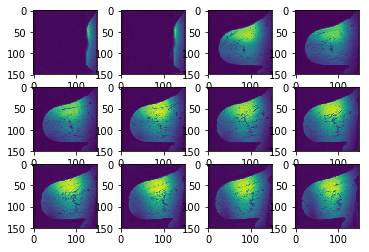

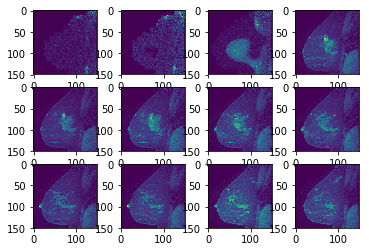

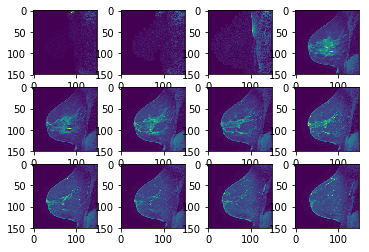

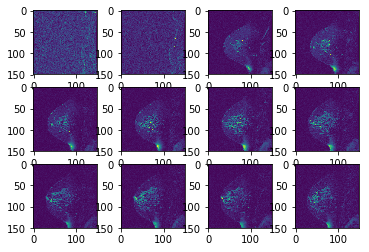

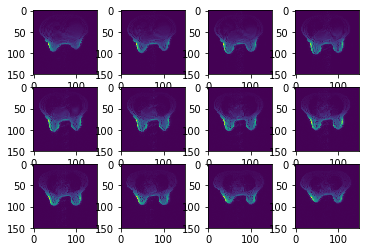

In [30]:
IMG_PX_SIZE = 150

for patient in patients[100:105]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR']
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    fig = plt.figure()
    for num, each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_image = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_image)
    plt.show()

There are marked variations in scan orientation, intensity, scale and pixel(RGB) values

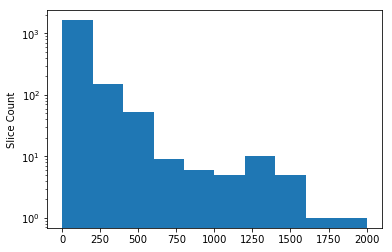

In [20]:
# Visualize number of slices in each scan
plt.hist(slice_count)
plt.xlabel('Number of slices')
plt.xlabel('Counts')
plt.yscale('log')

In [26]:
from statistics import median, mode
print('Maximum number of slices in a scan is: ', max(slice_count))
print('Minimum number of slices in a scan is: ', min(slice_count))
print('Median number of slices in a scan is: ', median(slice_count))
print('Modal number of slices in a scan is: ', mode(slice_count))

Maximum number of slices in a scan is:  2000
Minimum number of slices in a scan is:  1
Median number of slices in a scan is:  72
Modal number of slices in a scan is:  1


Some scans have as many as 2000 slices while some have as little as 1, median is 72, mode is 1

In [35]:
from collections import Counter
Counter(Modality)

Counter({'MG': 19, 'MR': 1858})

The Dataset contains 19 mamograms

In [41]:
# Scan Size variation

# read in dicom to array of lists with metadata
for patient in patients[:4]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1]
     for z in os.listdir(path+'/'+x+'/'+y)[:1] ]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    print (len(slices), slices[0].pixel_array.shape, slices[0].SliceThickness, label) 
    #print slices[0].SeriesDescription, slices[0].PatientOrientation

1 (512, 512) 3 [0]
1 (256, 256) 3 [0]
1 (256, 256) 3 [0]
1 (256, 256) 3 [1]


Scan dimension variations shown here. Some are 512px by 512px while others are 256px square

### Preprocessing

Images are from different parts of the world using different makes and models of MRI scanners and varying scan settings. Some scans turned out to be mammorgrams. Some scans had up to 140 slices while others had as few as 13. Scans also had different orientations. A lot of preprocessing is therefore necessary to normalize the data that gets fed into the conv net.

In [43]:
# Resize images and apply constraints on scan type and number of slices

IMG_PX_SIZE = 150
HM_SLICES = 20

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    """
    return the average number of .
    """
    return sum(l)/len(l)
        
for patient in patients[:10]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
             if len(os.listdir(path+'/'+x+'/'+y))>=12
             ]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    
    new_slices = []
    
    # normalize (resize) dimensions of each slice
    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = int(math.ceil(len(slices)/HM_SLICES))
    
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    print (len(slices), len(new_slices))
    '''
    fig = plt.figure()
    for num, each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()
    '''


13 13
40 20
192 20
61 16
72 18
430 20
46 16
45 15
36 18
53 18


For five patients extract about 10 representative slices from the group equally spaced out

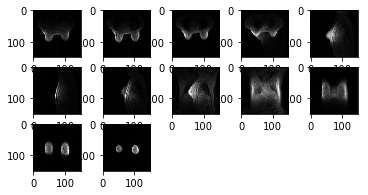

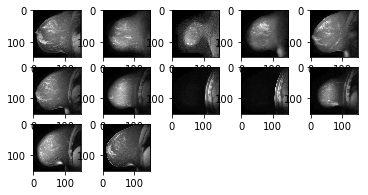

In [38]:
# Normalize number of slices per scan

IMG_PX_SIZE = 150
HM_SLICES = 12

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
for patient in patients[104:106]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR']
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    
    new_slices = []
    
    # normalize (resize) dimensions of each slice
    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = int(math.ceil(len(slices)/HM_SLICES))
    
    # normalize number of slices per scan
    # if number of slices is over threshold reduce, if less fill up
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    #print len(slices), len(new_slices)
    #'''
    fig = plt.figure()
    for num, each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()
    #'''

#### Full Preprocessing function

In [44]:
from time import time

data_dir = 'C:\TCIA-BRCA\DOI'

IMG_PX_SIZE = 50
HM_SLICES = 20

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
def process_data(scan_path, labels_brca, img_px_size=50, hm_slices=20, visualize=False):
    #print(scan_path)
    slices = [dicom.read_file(scan_path + '/' + s) for s in os.listdir(scan_path)]
    #slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if (slices[0].Modality=='MR' and len(slices)>=20) :
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        patient = slices[0].PatientID
        label = labels_brca['y'][labels_brca['patients']==patient].values
        #print (patient, len(slices), slices[0].pixel_array.shape, label,slices[0].Modality)
        
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        #img = cv.resize(img, (800, 800))
        #cv.normalize(img, img, 0, 255, cv.NORM_MINMAX)

        chunk_sizes = int(round(len(slices)/HM_SLICES))

        for slice_chunk in chunks(slices,chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)
        
        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            
        if len(new_slices) == HM_SLICES-3:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val
        
        if len(new_slices) == HM_SLICES+3:
            #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES:]
            #new_slices[HM_SLICES-2] = new_val
        
        if len(new_slices) == HM_SLICES+4:
            #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES:]
            #new_slices[HM_SLICES-3] = new_val
            
        if len(new_slices) == HM_SLICES+5:
            #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES:]
            #new_slices[HM_SLICES-3] = new_val

        if visualize:
            fig = plt.figure()
            for num, each_slice in enumerate(new_slices):
                y = fig.add_subplot(4,5,num+1)
                y.imshow(each_slice, cmap='gray')
                plt.show()
        
        if label==1:
            label = np.array([0,1])
        elif label==0:
            label = np.array([1,0])

        return np.array(new_slices), label, patient

    else :
        label = 0
        patient = ''
        return np.empty([1,1]), label , patient

much_data_patient = [] # all patients
pos_data_patients = [] # patients with late stage cancers
t0 = time()
for num, scan_path in enumerate(scan_paths):
    if num%100==0:
        print (num)
        
    try:
        img_data, label, patient = process_data(scan_path, labels_brca, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES)
        #print (img_data.shape, label)
        if img_data.shape == (20, 50, 50):
            #print (img_data.shape, label)
            much_data_patient.append([img_data, label, patient])
            if label[0]==0:
                pos_data_patients.append([img_data, label, patient])
    except KeyError as e:
        print ('unlabeled')

print('Elapsed time: ', time()-t0)
len(much_data_patient)
len(pos_data_patients)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
Elapsed time:  8806.188743114471


89

In [ ]:
# save preprocessed files to disk
np.save('muchdata-patient-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data_patient)

In [ ]:
# save positive images
np.save('pos-patients-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), pos_data_patients)

In [48]:
print(len(much_data_patient)) # 1554
print(len(pos_data_patients)) # 89

1554
89


In [49]:
from collections import Counter

y_labels = x = [image[1][0] for image in much_data_patient]
print(Counter(y_labels))

Counter({1: 1465, 0: 89})


Only 5% of the patients are late stage cancer leading to a class imbalance that will affect model performance. Image augmentation to the rescue

### Image Augmentation
The minority class is upsampled using a sequence of image augmentation techniques to reduce the severity of class imbalance so the model has enough samples to train on.

In [51]:
# create patient list to track patient IDs of minority class
patient_list = []
for image in pos_data_patients:
    patient_list.append(image[2])
print(len(patient_list))

89


In [52]:
# extract image array for augmentation
x = [image[0] for image in pos_data_patients]
print(len(x))
pos_data_array = np.asarray(x)
print(pos_data_array.shape)
images = pos_data_array

89
(89, 20, 50, 50)


In [106]:
# image augmentation

# http://imgaug.readthedocs.io/en/latest/source/examples_basics.html
import imgaug as ia
from imgaug import augmenters as iaa
import random
random.seed(5)

aug_imgs = []

rand_num = [random.random() for _ in range(0, 10)]
for sid in rand_num:
    ia.seed(54)

    # Define our sequence of augmentation steps that will be applied to every image.
    seq = iaa.Sequential([
        iaa.Fliplr(0.5*sid), # horizontally flip 50% of the images
        iaa.Affine(
            scale={"x": (1.2*sid, 2.5*sid), "y": (1.2*sid, 2.5*sid)},
            translate_percent={"x": (-0.1*sid, 0.1*sid), "y": (-0.1*sid, 0.1*sid)},
            rotate=(-10*sid, 10*sid)#,
        )
    ], random_order=True)
    # augment all images
    images_aug = seq.augment_images(images)
    label = np.array([0,1])
    for num, image_new in enumerate(images_aug):
        aug_imgs.append([image_new, label, patient_list[num]])
        #if num%25==0:
        #    print (num)
        
print(len(aug_imgs))

890


In [70]:
images_aug.shape # (89, 20, 50, 50)

890

In [ ]:
# save augmented images to disk
np.save('augmented-images-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), aug_imgs)

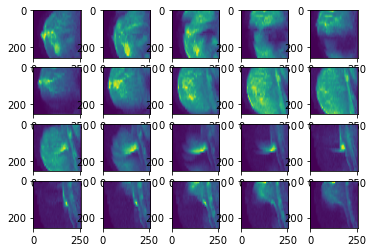

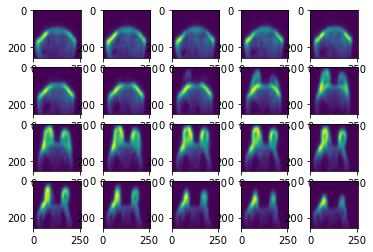

In [107]:
# visualize some augmented images
IMG_PX_SIZE = 256
for scan in aug_imgs[300:302]:
    #print len(slices), slices[0].pixel_array.shape, label
    fig = plt.figure()
    for num, each_slice in enumerate(scan[0][:20]):
        y = fig.add_subplot(4,5,num+1)
        new_image = cv2.resize(np.array(each_slice),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_image)
    plt.show()

## Setup Modeling, Train and Evaluate

### Load Original and Augmented Images to form new dataset
combine original and augmented positive patients into one array, then split into train and validation sets for training

In [ ]:
orig_patients = np.load('muchdata-patient-50-50-20.npy')
aug_patients = np.load('augmented-images-50-50-20.npy')

#### Split into train and test sets
Patients are split into 2 groups (train and test) and thier scans are assigned to these groups. This is important because each patient has multiple scans, so a random split of scans will leak scans of the same patient across train and test sets falsely improving model performance and violating algorithm assumptions. 

In [108]:
# Get unique list of patients and their class labels
patients = list(set(patients))
patients.sort()

patient_labels = []
for patient in patients:
    label = int(labels_brca['y'][labels_brca['patients']==patient].values)
    patient_labels.append(label)

print(patients[:10])
print(patient_labels[:10])

['TCGA-AO-A03M', 'TCGA-AO-A03V', 'TCGA-AO-A0J8', 'TCGA-AO-A0J9', 'TCGA-AO-A0JB', 'TCGA-AO-A0JF', 'TCGA-AO-A0JI', 'TCGA-AO-A0JM', 'TCGA-AO-A129', 'TCGA-AO-A12D']
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [109]:
# split patients into train and test sets
from sklearn.model_selection import train_test_split

X, y = patients, patient_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=54)

print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

97 97
42 42


In [110]:
from collections import Counter
print(Counter(patient_labels))
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 131, 1: 8})
Counter({0: 92, 1: 5})
Counter({0: 39, 1: 3})


### Normalize image data and split
For each image in the original and augmented datasets, assign to train or test set based on patient ID

In [112]:
# check each of the 1554 elements of much_data_patient (a list of lists [image, label, patient])
# if index[2] (patient ID) in X_train, assign that [scan, label] to train_set
# else assign elem to validation_set
orig_and_aug = [much_data_patient,aug_imgs]
validation_set=[]
train_set=[]
for group in orig_and_aug:
    for num, elem in enumerate(group):
        img = elem[0]
        # normalize
        mean = np.mean(img)
        stdev = np.std(img)
        if stdev!=0:
            img = img-mean
            img = img/stdev
            #print(mean,stdev)
            if elem[2] in X_test:
                validation_set.append([np.array(img),np.array(elem[1])])
            else:
                train_set.append([np.array(img),np.array(elem[1])])
        if num%200==0:
            print (num, 'Done!')

print(len(validation_set), len(train_set))

0 Done!
200 Done!
400 Done!
600 Done!
800 Done!
1000 Done!
1200 Done!
1400 Done!
0 Done!
200 Done!
400 Done!
600 Done!
800 Done!
718 1714


In [ ]:
# save training and validation sets to disk
np.save('validation-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), validation_set)
np.save('train-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), train_set)

### Training
Load training and validation sets, take a random sample of 1000 training examples and 500 validation examples.
Extract true labels for validation set for model evaluation the Train Conv net!

In [116]:
train = np.load('train-50-50-20.npy')
validation = np.load('validation-50-50-20.npy')
print(train.shape)

(1685, 2)


In [117]:
import random
random.seed(5)

idxTrain = random.sample(range(0, len(train)), 1000)
idxTest = random.sample(range(0, len(validation)), 500)

train_data= train[idxTrain]
validation_data= validation[idxTest]

print(train_data.shape)
print(validation_data.shape)

(1000, 2)
(500, 2)


In [118]:
# extract labels for validation set
y_true = [i[1].tolist() for i in validation_data] # convert labels from array to lists
y_true = [0 if i == [1,0] else 1 for i in y_true] # convert from lists to binary
print(y_true[:10])

[0, 1, 0, 1, 0, 0, 1, 1, 1, 1]


### Tensorflow: Setup Convolution Neural Network Architecture and Variables

In [120]:
import tensorflow as tf

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.7

In [122]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [126]:
def convolutional_neural_network(x):
    #                # 3 x 3 x 3 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       3 x 3 x 3 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  128 features
               'W_conv3':tf.Variable(tf.random_normal([3,3,3,64,128])),
               #                                  1024 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
              'b_conv3':tf.Variable(tf.random_normal([128])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)
    
    conv3 = tf.nn.relu(conv3d(conv2, weights['W_conv3']) + biases['b_conv3'])
    conv3 = maxpool3d(conv3)  
    
    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [128]:
import time
def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    saver = tf.train.Saver()
    
    hm_epochs = 4
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        successful_runs = 0
        total_runs = 0
        t0=time.time()
        print('start time: ', t0)
        for epoch in range(hm_epochs):
            t0_epoch=time.time()
            #print(t0_epoch)
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
           
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
            print ('Epoch', epoch+1, "training time:", round(time.time()-t0_epoch, 3), "s") # the time would be round to 3 decimal in seconds
            t1=time.time()

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            print ('Epoch', epoch+1, "predict time:", round(time.time()-t1, 3), "s")
        
        print('Done! Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        prediction_out = sess.run(prediction, feed_dict={x: [i[0] for i in validation_data]})

        # predicted labels
        classification = sess.run(tf.argmax(prediction, 1), feed_dict={x: [i[0] for i in validation_data]})
        print(classification)
        
        classification2 = prediction.eval({x: [i[0] for i in validation_data]})
        
        print ("Total time:", round(time.time()-t0, 3), "s")
        
        # save model
        saver.save(sess, 'C:/Users/Toby/ipython notebooks/tf_model4/brca-tf-cnn-model4.ckpt')
        print('fitment percent:',successful_runs/total_runs)
        return prediction, prediction_out, classification, classification2

# Run this locally:
prediction, prediction_out, classification, classification2 = train_neural_network(x)

start time:  1509723828.209512
Epoch 1 completed out of 4 loss: 262480799.707
Epoch 1 training time: 1677.444 s
Accuracy: 0.808
Epoch 1 predict time: 40.697 s
Epoch 2 completed out of 4 loss: 29024589.6943
Epoch 2 training time: 1641.731 s
Accuracy: 0.77
Epoch 2 predict time: 38.759 s
Epoch 3 completed out of 4 loss: 8574424.04395
Epoch 3 training time: 1659.6 s
Accuracy: 0.792
Epoch 3 predict time: 38.804 s
Epoch 4 completed out of 4 loss: 4246483.76367
Epoch 4 training time: 1642.007 s
Accuracy: 0.798
Epoch 4 predict time: 40.213 s
Done! Finishing accuracy:
Accuracy: 0.788
[0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0
 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0
 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0
 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0
 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 

### Model Evaluation

In [ ]:
# restore saved model and evaluate

def TensorflowPredict(model_path, model_filename):
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph(model_path + model_filename)
        new_saver.restore(sess, tf.train.latest_checkpoint(model_path))
        y_pred = sess.run(tf.argmax(prediction, 1), feed_dict={x: [i[0] for i in validation_data]})
        return y_pred

path = 'C:/Users/Toby/ipython notebooks/tf_model5/'
filename = 'brca-tf-cnn-model5.ckpt.meta'
y_pred = TensorflowPredict(path, filename)
print (y_pred)

AUC 0.800430148947


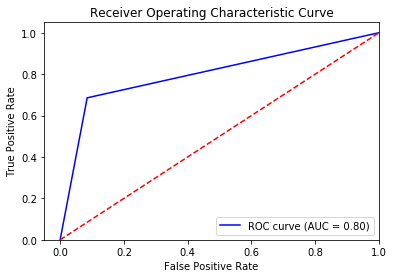

Accuracy 0.794
Precision 0.900497512438
Recall 0.685606060606
f1_score 0.778494623656
confusion_matrix
[[216  20]
 [ 83 181]]
None


In [130]:
from sklearn import metrics 

def TensorflowModelEval(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    tn, fn, tp, fp = cm[0,0], cm[1,0], cm[1,1], cm[0,1]
    
    fpr, tpr, tresholds = metrics.roc_curve(y_true, y_pred)
    print('AUC', metrics.auc(fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='b', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(-0.05,1)
    plt.ylim(0,1.05)
    plt.show()
    
    print ('Accuracy', metrics.accuracy_score(y_true, y_pred))
    print ("Precision", metrics.precision_score(y_true, y_pred))
    print ("Recall", metrics.recall_score(y_true, y_pred))
    print ("f1_score", metrics.f1_score(y_true, y_pred))
    print ("confusion_matrix")
    print (metrics.confusion_matrix(y_true, y_pred))
    

print (TensorflowModelEval(y_true, classification))

## Keras Implementation

## Genomic Data

### Import libraries

In [76]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB

### Read in Pre-processed RNASeq file

In [8]:
def readRNA(filepath):
    """
    Takes the path to preprocessed Illumina HiSeq RNASeq data, 
    reads in the data and drops unneccesary variables
    Input: string-- path to file 
    Output: pandas dataframe
    """
    rna = pd.read_table(filepath,
                  sep='\t', na_values='NA',low_memory=False )
    rna = rna.drop(['pat.bcr','stage', 'class.y', 
                    'patient.stage_event.pathologic_stage'],axis=1)
    return rna

rnafile = 'D:\Insight\RNASeq2.txt'
rna = readRNA(rnafile)
print(rna.head())
print(rna.shape)

   ?|100130426  ?|100133144  ?|100134869    ?|10357     ?|10431  ?|136542  \
0          0.0     4.740894     1.850690  21.147799   85.855098       0.0   
1          0.0     5.538907     2.289837  13.757862  164.300537       0.0   
2          0.0     4.852649     2.258469  30.817610  260.711091       0.0   
3          0.0     2.738411     1.568381  17.688679  138.959750       0.0   
4          0.0     2.839404     1.474279  14.306604  142.381038       0.0   

    ?|155060   ?|26823  ?|280660  ?|317712   ...     ZXDB|158586  ZXDC|79364  \
0  17.243280  0.827206       0.0       0.0   ...       14.145284   64.301618   
1   7.731220  1.643382       0.0       0.0   ...       21.564148   79.748326   
2  11.166437  1.183824       0.0       0.0   ...       37.068483   94.620257   
3  17.741902  0.091912       0.0       0.0   ...       14.219784   48.010603   
4  16.554101  0.693015       0.0       0.0   ...       13.020350   55.540458   

   ZYG11A|440590  ZYG11B|79699    ZYX|7791  ZZEF1|23140 

### Preprocess data

In [9]:
def encodeLabel(rnaData) :
    """
    Takes dataframe with RNA expression data and class variable,
    uses the label encoder to convert the class variable to binary
    Input: pandas dataframe
    Output: pandas dataframe with binary class labels
    """
    encoder = LabelEncoder()
    encoder.fit(rnaData["class.x"])
    rnaData['class'] = encoder.transform(rnaData["class.x"])
    rnaLabels = rnaData['class']
    rnaData = rnaData.drop(['class.x','class'],axis=1)
    return rnaData, rnaLabels

rna, rnaLabels = encodeLabel(rna)

In [10]:
# count class labels- early and late stage
print(Counter(rnaLabels))

Counter({0: 783, 1: 95})


### Feature Selection

In [11]:
def removeZeroVar(rnaData):
    """
    Takes dataframe with RNASeq expression data and
    removes genes with zero variance
    Input: pandas dataframe
    Output: 
        selectorVar -- selector object
        rnaData -- dataframe with zero variance genes removed
    """
    selectorVar = VarianceThreshold()
    rnaData = selectorVar.fit_transform(rnaData)
    return selectorVar, rnaData

print('Initial Shape: ', rna.shape)
selectorVar, rna = removeZeroVar(rna)
print('Shape after Zero variance variables removed', rna.shape)

Initial Shape:  (878, 20532)
Shape after Zero variance variables removed (878, 20524)


In [12]:
def selectPerc(rnaData, rnaLabels, percentile) :
    """
    A wrapper for the selectPercentile function that performs univariate feature selection.
    Takes a dataframe and class labels, and selects the proportion of variables
    specified using the percentile parameter
    Input: 
        rnaData -- pandas dataframe
        rnaLabels -- list
        percentile -- integer
    Output:
        selectorPer -- selector object
        rna_uni -- dataframe with selected features
    """
    selectorPer = SelectPercentile(f_classif, percentile=percentile)
    rna_uni = selectorPer.fit_transform(rnaData, rnaLabels)
    rna_uni = pd.DataFrame(rna_uni)
    return selectorPer, rna_uni

selectorPer, rna_uni = selectPerc(rna, rnaLabels, percentile=1.5)

### Normalize

In [13]:
def rnaNorm(rnaData) :
    """
    Wrapper for sklearn StandardScaler function removing the mean and scaling to unit variance. 
    Takes dataframe with unscaled features, standardizes and returns scaled features.
    Input: dataframe
    Output: 
        rna_norm -- normalized pandas dataframe
        scaler -- scaler object
    """
    scaler = StandardScaler().fit(rnaData)
    rna_scaled = scaler.transform(rnaData)
    rna_norm = pd.DataFrame(rna_scaled)
    return rna_norm, scaler

rna_norm, scaler = rnaNorm(rna)
rna_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,20514,20515,20516,20517,20518,20519,20520,20521,20522,20523
0,-0.394018,0.004135,-0.083980,-0.259281,-1.122976,-0.140814,0.044922,-0.410354,-0.086475,-0.050736,...,-0.376954,-0.670711,-0.473050,-0.906080,-0.222213,0.234640,-0.076043,-0.104028,0.396917,-0.140999
1,-0.394018,0.335760,0.254234,-0.609912,-0.307966,-0.140814,-0.729964,0.670680,-0.086475,-0.050736,...,0.459657,-0.226771,0.043002,-0.723470,-0.354528,-0.225956,-0.245852,0.130250,-0.368559,-0.749939
2,-0.394018,0.050576,0.230075,0.199523,0.693693,-0.140814,-0.450119,0.061989,-0.086475,-0.050736,...,1.802107,0.700997,0.539851,-0.271005,0.478702,0.494169,-0.031611,0.581650,2.183050,0.011236
3,-0.394018,-0.828023,-0.301403,-0.423406,-0.571244,-0.140814,0.085542,-1.384259,-0.086475,-0.050736,...,-0.703641,-0.666252,-1.017308,-0.471351,-0.950302,-0.076471,-1.071846,-1.188969,-0.510984,-0.902174
4,-0.394018,-0.786054,-0.373877,-0.583875,-0.535699,-0.140814,-0.011221,-0.588092,-0.086475,-0.050736,...,-0.813781,-0.738026,-0.765747,-1.040926,-0.999555,-0.832589,-0.126685,-1.008379,-0.547915,-0.826056


### Split into train and test sets

In [18]:
def splitRNA(rnaData, rnaLabels, test_size, valid_size, random_state) :
    """
    Wrapper for sklearn train_test_split function that splits a dataset into
    train and test sets using the test_size parameter
    Input: 
        rnaData -- features
        rnaLabels -- labels
        test_size -- proportion of data assigned to test set
        random_state -- random seed
    Output: train and test set Arrays
    """
    X_train, X_test, y_train, y_true = train_test_split(rnaData, rnaLabels, 
                                                        test_size=test_size, 
                                                        random_state=random_state,
                                                       stratify = rnaLabels)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                        test_size=valid_size, 
                                                        random_state=random_state,
                                                       stratify = y_train)
    return  X_train, X_test, X_valid, y_train, y_true, y_valid

X_train, X_test, X_valid, y_train, y_true, y_valid = splitRNA(rna_norm, rnaLabels, test_size=0.1, valid_size=0.2, random_state=62)

In [19]:
# Shapes and Value counts
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_true.shape)
print(y_valid.shape)
print(y_train.value_counts())
print(y_true.value_counts())
print(y_valid.value_counts())

(658, 20524)
(220, 20524)
(658,)
(220,)
0    587
1     71
Name: class, dtype: int64
0    196
1     24
Name: class, dtype: int64


### Handling class imbalance with SMOTE
The positive class is about 11% of the data in both train and test sets.
This might be problematic for the machine learning models as more weight will be assigned to the dominant class.
This can be corrected using the SMOTE function from imblearn

oversampling minority class using SMOTE (Synthetic Minority Oversampling Technique).
https://beckernick.github.io/oversampling-modeling/

In [88]:
def upsampleSMOTE(train_features, train_labels) :
    """
    Takes something and does something
    Input: 
        train_features -- array of training features
        train_labels -- array of training labels
    Output: 
        x_train_res -- array of resampled features
        y_train_res -- array of resampled labels
    """
    sm = SMOTE(random_state=12, ratio = 'minority')
    x_train_res, y_train_res = sm.fit_sample(train_features, train_labels)
    return  x_train_res, y_train_res

x_train_res, y_train_res = upsampleSMOTE(X_train, y_train) 
x_test_res, y_test_res = upsampleSMOTE(X_test, y_true) 

### Dimensionality Reduction with PCA

In [47]:
def reducePCA(train_features, test_features, resampled_train, n_components):
    """
    Wrapper for sklearn PCA function that performs Linear dimensionality reduction 
    using Singular Value Decomposition of the data to project it to a lower dimensional space.
    It is an orthogonal transformation to convert a set of observations of possibly correlated variables 
    into a set of values of linearly uncorrelated variables called principal components.
    Takes training features, fits the data and returns the pca object
    Input: 
        train_features -- array of training features
        test_features -- array of test features
        resampled_train -- array of SMOTE-resampled training features
        n_components -- number of principal components to return
    Output:
        pca -- pca object
        rna_pca_train -- array of training set prinicipal components
        rna_pca_test -- array of test set prinicipal components
    """
    pca = PCA(n_components=n_components, random_state=0)
    pca.fit(train_features)
    rna_pca_train = pca.transform(resampled_train)
    rna_pca_test = pca.transform(test_features)
    return pca, rna_pca_train, rna_pca_test

pca, rna_pca_train, rna_pca_test = reducePCA(X_train, x_train_res, X_test, n_components=100)

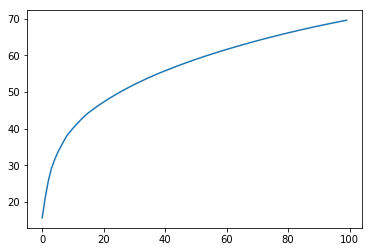

In [48]:
def screePlot(pcaObject) :
    """
    Takes PCA object and plots cumulative explained variance ratio
    of all principal components
    Input: pca object
    Output: plot
    """
    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.plot(var1)
    return

screePlot(pca)

### Modeling
The function for evaluating each model is presented first.
This function is used several times to plot/output several model metrics.
F1-score is the most important of all metrics returned

#### Evaluate Models/Model Metrics

In [49]:
def modelEval(test_class, pred, probabs):
    """
    Takes the arrays of actual class values, the predicted class values and 
    their probabilites, computes the confusion matrix, tpr and fpr and auc.
    Plots the ROC curve, and returns model evaluation metrics- sensitivity,
    specificity, accuracy, F1 score and AUC
    """
    cm = metrics.confusion_matrix(test_class, pred)
    tn, fn, tp, fp = cm[0,0], cm[1,0], cm[1,1], cm[0,1]
    fpr, tpr, threshold = metrics.roc_curve(test_class, probabs)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='b', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(-0.05,1)
    plt.ylim(0,1.05)
    plt.show()
    sens = tp / float(tp + fn)
    print ('Sensitivity: ', sens)
    specf = tn / float(fp + tn)
    print ('Specificity: ', specf)
    accu = metrics.accuracy_score(test_class, pred)
    print ('Accuracy: ', accu) 
    f1s = metrics.fbeta_score(test_class, pred, beta=1)
    print ('F1 score: ', f1s)
    auc1 = metrics.auc(fpr, tpr)
    print ('AUC: ', auc1)
    precision = metrics.precision_score(test_class, pred, average='weighted')
    print ('Precision: ', precision) 
    return "\n"


In [90]:
def modelMetrics(clf, train_X, train_y, test_X, test_y):
    """
    Wrapper for modelEval functioin. Takes trained classifier,
    fits a model to the training set, predicts on the test set, 
    and evaluates the model
    Input: dtype
    Output: dtype
    """
    estimator = clf.fit(train_X, train_y)
    y_pred = estimator.predict(test_X)
    probs = estimator.predict_proba(test_X)[:, 1]
    print (modelEval(test_y, y_pred, probs))
    return 'Done!'

#### Grid Search

In [82]:
# Pipeline -- pca --> logistic regression

def PCAgridSearch(train_X, train_y, scoring='f1', cv=5, random_state=5) :
    """
    Wrapper for GridsearchCV function that finds the best parameters
    for a pipeline that peforms dimensionality reduction with pca 
    (finds best n_components) and a classifier (best parameters)
    and returns the best estimator
    Input: 
        train_X, train_y -- arrays, training set features and labels
        scoring -- string, scoring parameter (usually 'f1', 'accuracy', or 'recall')
        cv -- integer, number of cross validation splits
    Output: best estimator
    """
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn import linear_model, decomposition
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    from sklearn.naive_bayes import GaussianNB
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.decomposition import PCA
    from scipy.stats import randint as sp_randint
    from sklearn import svm

    logistic = linear_model.LogisticRegression(random_state=random_state)
    GNB = GaussianNB()
    RF =  RandomForestClassifier(n_jobs= -1,random_state=random_state)
    GBM = GradientBoostingClassifier()
    svr = svm.SVC() #kernel='rbf',C=1,gamma=10

    pca = decomposition.PCA()
    pca.fit(train_X)
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    #pipe = Pipeline(steps=[('pca', pca), ('svr', svr)])
    #pipe = Pipeline(steps=[('pca', pca), ('GBM', GBM)])
    #pipe = Pipeline(steps=[('pca', pca), ('RF', RF)])
    #pipe = Pipeline(steps=[('pca', pca), ('GNB', GNB)])

    # pca params
    n_components = [400, 600, 800, 1000, 1500, 2000]
    
    # LR params
    Cs = np.logspace(-4, 4, 3)
    
    # rf/gbm parameters
    GBMparams = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
              'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    RFparams= {'n_estimators': 1500, 'max_depth': 3,'min_samples_leaf': 1, 'random_state': 3,
               'n_jobs': -1}
    max_depth= [3, 5, 8]
    mtries=[1,2,3]
    n_estimators = [100,500,1000,1500]
    learning_rate=[0.1, 0.01, 0.001]
    max_features=sp_randint(1, 11)
    min_samples_split=sp_randint(2, 11)
    min_samples_leaf=sp_randint(1, 11)
    subsample=[0.5,1.0]
    bootstrap=[True, False],
    criterion=["friedman_mse", "mae"]
    
    # svr parameters
    kernel=['linear', 'rbf','poly']
    C=[0.01, 0.1, 1, 10, 100, 1000]
    gamma=[0.0001,0.001,0.01, 0.1, 1,10]
    degree=[1,2,3]
    n_jobs= -1

    # Randomized Search
    # n_iter_search = 20
    #random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
    #                                   n_iter=n_iter_search)

    # Grid Search
    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,logistic__C=Cs), 
                             cv=cv, scoring=scoring,verbose=1, n_jobs=-1)
    #estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,logistic__C=Cs), 
    #                         cv=5, scoring=scoring,verbose=5)
    #estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,RF__n_estimators=n_estimators,
    #                                  RF__max_depth=max_depth), cv=4, scoring=scoring)
    #estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,svr__kernel=kernel,
    #                                  svr__C=C, svr__gamma=gamma,svr__degree=degree ), 
    #                         cv=5, scoring=scoring)
    estimator.fit(train_X, train_y)
    return estimator

estimator = PCAgridSearch(x_train_res, y_train_res)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.5min finished


In [83]:
print(estimator.best_estimator_)
print(estimator.best_score_)
print(estimator.best_params_)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=600, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
0.963553573455
{'logistic__C': 10000.0, 'pca__n_components': 600}


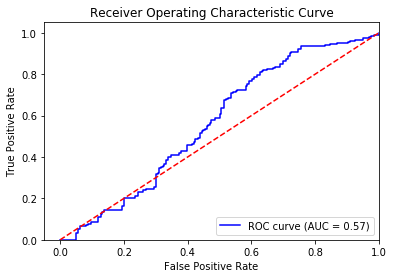

Sensitivity:  0.0102040816327
Specificity:  0.948979591837
Accuracy:  0.479591836735
F1 score:  0.0192307692308
AUC:  0.565051020408
Precision:  0.328070175439




In [89]:
def evalGridSearch(clf, test):
    y_pred = clf.predict(test)
    probs = clf.predict_proba(test)[:, 1]
    print (modelEval(y_test_res, y_pred, probs))
    return

evalGridSearch(estimator, x_test_res)

#### Stacked Classifier

In [57]:
# Stacked Classifier (Ensemble Stacking, Super Learner, Metalearner)
# https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#example-1-simple-stacked-classification
# https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

def stackLearner(train_X, train_y, scoring=None) :
    """
    Takes training features and labels, uses a stacked classifier from mlxtend
    to combine 3 models and returns the stacked classifier
    Input: array of training features and labels
    Output: stacked classifier object
    """ 
    from sklearn import model_selection
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB 
    from sklearn.ensemble import RandomForestClassifier
    from mlxtend.classifier import StackingClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    import numpy as np

    clf1 = KNeighborsClassifier(n_neighbors=1)
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    lr = LogisticRegression()
    gbm = GradientBoostingClassifier()
    sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                              meta_classifier=gbm, use_probas = True)

    print('5-fold cross validation:\n')

    for clf, label in zip([clf1, clf2, clf3, sclf], 
                          ['KNN', 
                           'Random Forest', 
                           'Naive Bayes',
                           'StackingClassifier']):

        scores = model_selection.cross_val_score(clf,train_X, train_y, 
                                                  cv=5, scoring=scoring)
        print(scoring, ": %0.2f (+/- %0.2f) [%s]" 
              % (scores.mean(), scores.std(), label))
    return sclf

sclf = stackLearner(x_train_res, y_train_res, scoring ='f1')

5-fold cross validation:

f1 : 0.67 (+/- 0.01) [KNN]
f1 : 0.87 (+/- 0.14) [Random Forest]
f1 : 0.90 (+/- 0.03) [Naive Bayes]
f1 : 0.73 (+/- 0.12) [StackingClassifier]


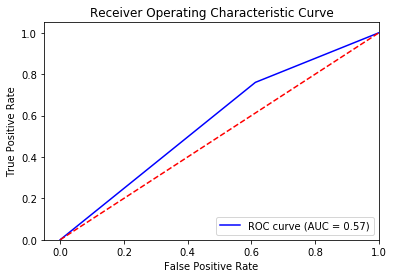

Sensitivity:  0.760204081633
Specificity:  0.387755102041
Accuracy:  0.573979591837
F1 score:  0.640860215054
AUC:  0.573979591837
Precision:  0.585894762293




'Done!'

In [91]:
# Stacked Classifier
modelMetrics(sclf,x_train_res, y_train_res, x_test_res, y_test_res)

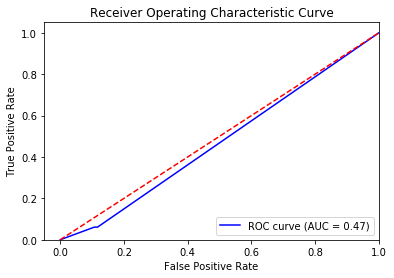

Sensitivity:  0.0612244897959
Specificity:  0.892857142857
Accuracy:  0.477040816327
F1 score:  0.10480349345
AUC:  0.472251145356
Precision:  0.425550772347




'Done!'

In [92]:
# Naive Bayes
modelMetrics(GaussianNB(),x_train_res, y_train_res, x_test_res, y_test_res)

# Clinical Data

In [ ]:
def do(input) :
    """
    Takes something and does something
    Input: dtype
    Output: dtype
    """
    
    return 

In [ ]:
## Putting it all together

In [ ]:
def do(input) :
    """
    Takes something and does something
    Input: dtype
    Output: dtype
    """
    
    return 

In [ ]:
## Conclusion